In [1]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [ ]:
def load_track_metadata(filepath):
    """Loads track metadata and returns the top track genre, track title, and
    artist name of the 'small' subset of tracks.
    
    Parameters
    ..........
    filepath - str
        Should point to the tracks.csv file from the free music archive
    """
    
    tracks = utils.load('../data/fma_metadata/tracks.csv')
    
    
    # these are the only metadata I want at the moment

    track_metadata = ['track_genre_top', 'track_title', 'artist_name']

In [3]:
tracks = utils.load('../data/fma_metadata/tracks.csv')
features = utils.load('../data/fma_metadata/features.csv')

In [4]:
audio_features = set(features.columns.get_level_values(0))
audio_features

{'chroma_cens',
 'chroma_cqt',
 'chroma_stft',
 'mfcc',
 'rmse',
 'spectral_bandwidth',
 'spectral_centroid',
 'spectral_contrast',
 'spectral_rolloff',
 'tonnetz',
 'zcr'}

**Interpretation:** These are the audio features included in the free music archive.

In [5]:
set(features['mfcc'].columns.get_level_values(0))

{'kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std'}

**Interpretation:** These are the statistics provided for the above audio features.

In [6]:
# https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns

tracks.columns = ['_'.join(col) for col in tracks.columns.to_flat_index()]
features.columns = ['_'.join(col) for col in features.columns.to_flat_index()]

In [7]:
smol_tracks = tracks.loc[tracks['set_subset'] == 'small']

**Interpretation:** I have mp3 data for the 'small' subset only at this point.

In [8]:
smol_tracks.shape

(8000, 52)

In [9]:
smol_tracks.isna().sum().sort_values(ascending=False)[:25]

track_lyricist              7974
track_publisher             7924
track_information           7841
track_composer              7820
artist_active_year_end      7642
artist_wikipedia_page       7590
track_date_recorded         7535
artist_related_projects     7306
artist_associated_labels    7151
track_language_code         6995
album_engineer              6858
album_producer              6596
artist_active_year_begin    6458
artist_longitude            5101
artist_latitude             5101
artist_members              4475
album_date_released         2663
artist_location             2529
artist_bio                  2086
artist_website              1548
album_information           1498
album_type                   231
track_license                  5
track_interest                 0
track_genres_all               0
dtype: int64

**Interpretation:** This metadata dataset has many null values but I will be working with the audio features dataset and am only interested in the 'genre' column from this dataset.

In [10]:
features.isnull().sum().sort_values(ascending=False)[:5]

chroma_cens_kurtosis_01    0
mfcc_median_13             0
mfcc_skew_03               0
mfcc_skew_02               0
mfcc_skew_01               0
dtype: int64

**Interpretation:** No null values in the feature dataframe is music to my ears.

In [11]:
# these are the only metadata I want at the moment

track_metadata = ['track_genre_top', 'track_title', 'artist_name']

In [12]:
df = features.merge(smol_tracks[track_metadata],
                    left_index=True, right_index=True)

In [13]:
smol_tracks.index = smol_tracks.index.astype('string')

In [14]:
df['track_genre_top'].value_counts(normalize=True)

Electronic             0.125
Experimental           0.125
Folk                   0.125
Hip-Hop                0.125
Instrumental           0.125
International          0.125
Pop                    0.125
Rock                   0.125
Blues                  0.000
Classical              0.000
Country                0.000
Easy Listening         0.000
Jazz                   0.000
Old-Time / Historic    0.000
Soul-RnB               0.000
Spoken                 0.000
Name: track_genre_top, dtype: float64

In [15]:
df.head()

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01,track_genre_top,track_title,artist_name
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,Hip-Hop,Food,AWOL
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,Hip-Hop,This World,AWOL
10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800,Pop,Freeway,Kurt Vile
140,0.533579,-0.623885,-1.086205,-1.081079,-0.765151,-0.072282,-0.882913,-0.582376,-0.884749,-0.645214,...,11.052547,0.379395,0.052379,0.036621,0.001953,3.143968,0.057712,Folk,Queen Of The Wires,Alec K. Redfearn & the Eyesores
141,0.172898,-0.284804,-1.169662,-1.062855,-0.706868,-0.708281,-0.204884,0.023624,-0.642770,-0.786291,...,32.994659,0.415527,0.040267,0.034668,0.002930,4.204097,0.028665,Folk,Ohio,Alec K. Redfearn & the Eyesores


In [16]:
for dtype in df.dtypes:
    if dtype != np.number:
        print(dtype)

category
object
object


<ipython-input-16-6ed53c4ae0e6>:2: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if dtype != np.number:


**Interpretation:** The only features that are non numerical are the three metadata columns which is what I expect.

In [17]:
df.index = df.index.astype('string')

**Interpretation:** Changing the index to a string helps with indexing.

In [18]:
df.drop(['99134', '98567', '98569', '108925', '98565', '133297'], inplace=True)

**Interpretation:** These tracks have known issues and should be removed per the [github wiki.](https://github.com/mdeff/fma/wiki)

In [23]:
# df.to_csv('../data/features_with_genres.csv')

In [24]:
corr = df.corr()

In [25]:
print(df.drop(columns=track_metadata).shape[1])

print('\n', len([value for value in np.triu(corr).flatten() if value == 1]))

518

 518


**Interpretation:** The ones in the correlation matrix come from the features interacting with themselves and can be removed.

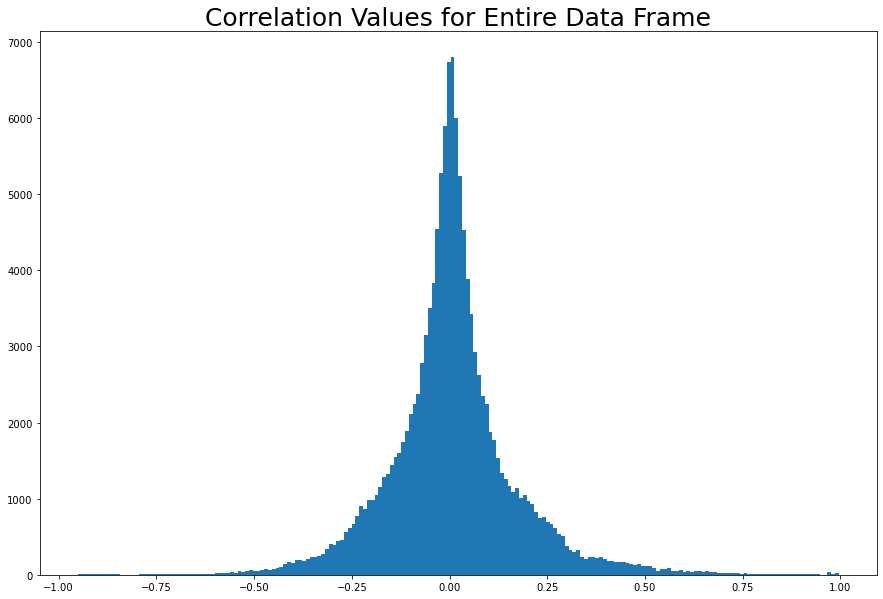

In [27]:
corr_values = [value for value in np.triu(corr).flatten()
               if (value != 0) and (value != 1)]

plt.figure(figsize = (15,10))
plt.hist(corr_values, bins=200)
plt.title('Correlation Values for Entire Data Frame', size=25);

**Interpretation:** There are some features that are highly correlated with others but the majority of the features are not very correlated with each other.

In [20]:
mfcc_df = df[[col for col in df.columns if 'mfcc' in col]]

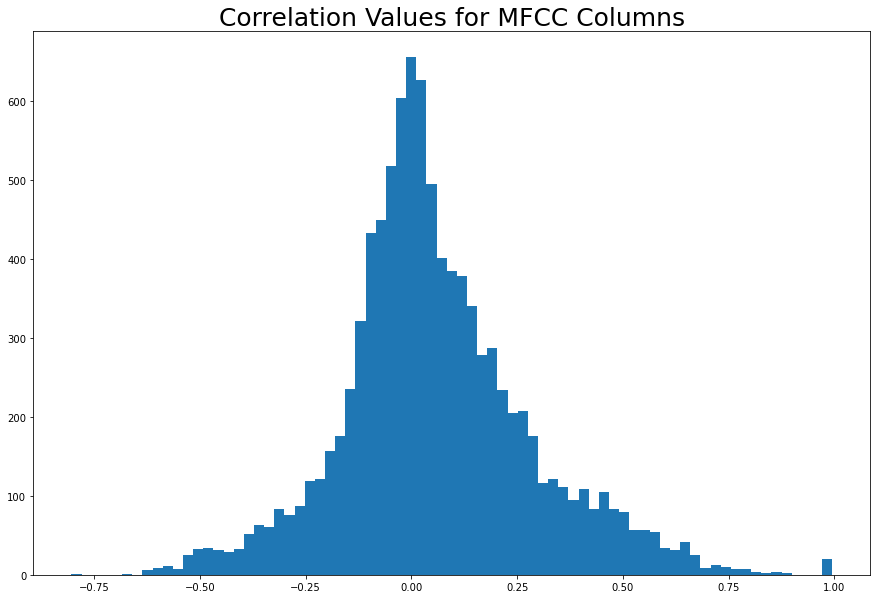

In [31]:
corr_values = [value for value in np.triu(mfcc_df.corr()).flatten()
               if (value != 0) and (value != 1)]

plt.figure(figsize = (15,10))
plt.hist(corr_values, bins=75)
plt.title('Correlation Values for MFCC Columns', size=25);

**Interpretation:** There are some features that are highly correlated with others but the majority of the features are not very correlated with each other.